In [6]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential,models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
import zipfile

content_zip = zipfile.ZipFile('./../../../../Downloads/data/archive.zip')
content_zip.extractall("./data")
content_zip.close()

In [28]:
ls './data/Face Mask Dataset/'

Test/       Train/      Validation/


In [29]:
path = './data/Face Mask Dataset/'
dataset = {'image_path':[],'mask_status':[],'where':[]}

for where in os.listdir(path):
    for status in os.listdir(path + '/' + where):
        for image in glob.glob(path + where +'/'+ status + '/'+ '*.png'):
            dataset['image_path'].append(image)
            dataset['mask_status'].append(status)
            dataset['where'].append(where)



In [31]:
df = pd.DataFrame(dataset)

Mask_True 5883
Mask_False 5909


<Axes: xlabel='mask_status', ylabel='count'>

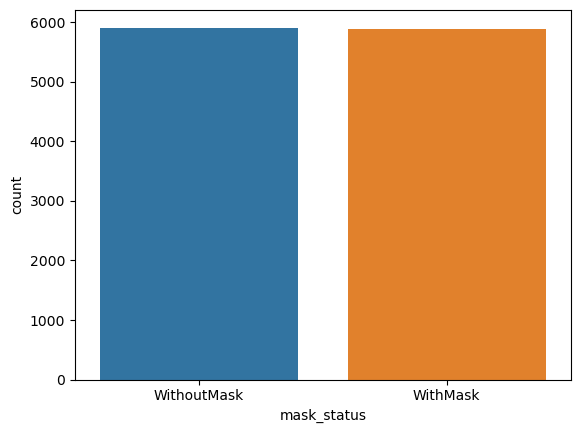

In [32]:
print('Mask_True',df.value_counts('mask_status')['WithMask'])
print('Mask_False',df.value_counts('mask_status')['WithoutMask'])
sns.countplot(x=df.mask_status)

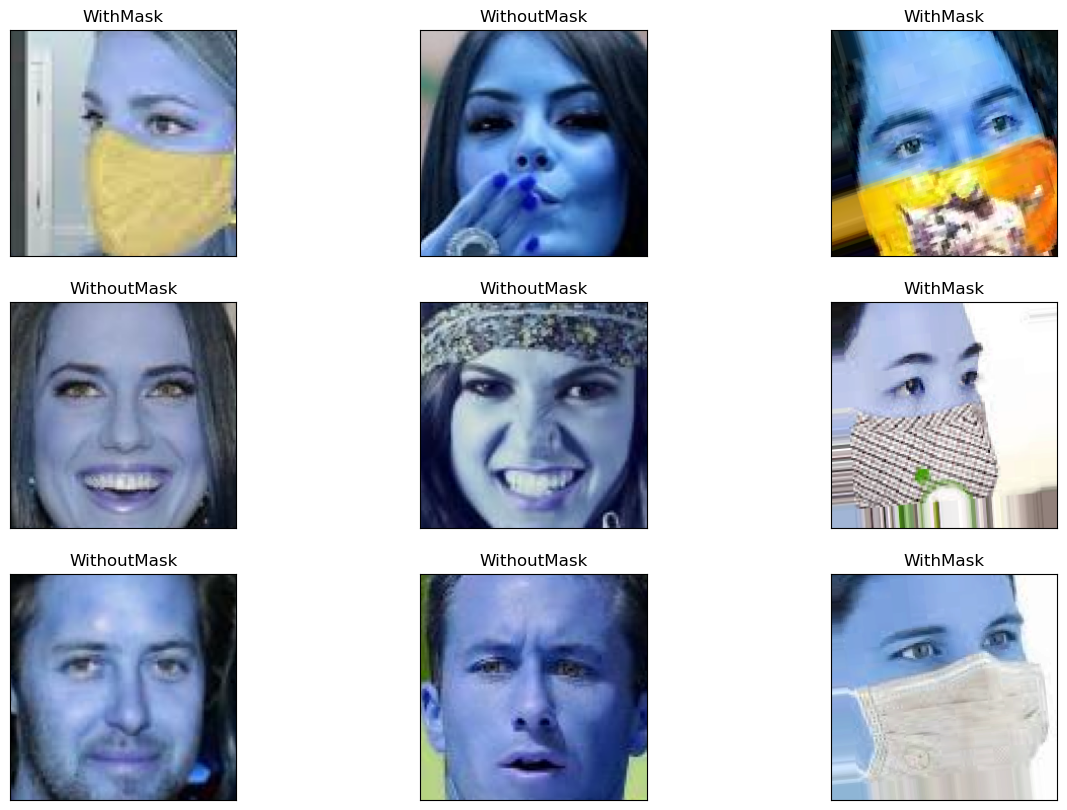

In [34]:
import cv2

plt.figure(figsize=(15,10))
for i in range(9):
    random = np.random.randint(1,len(df))
    plt.subplot(3,3,i+1)
    plt.imshow(cv2.imread(df.loc[random,'image_path']))
    plt.title(df.loc[random,'mask_status'])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [35]:
train_df = df[df['where']=='Train']
test_df = df[df['where']=='Test']
valid_df = df[df['where']=='Validation']

train_df.shape,test_df.shape,valid_df.shape

((10000, 3), (992, 3), (800, 3))

In [36]:
train_df.reset_index(drop=True,inplace=True)

In [37]:
data = []
image_size = 150

for i in range(len(train_df)):
    #그레이스케일로 컨버트
    img_array = cv2.imread(train_df['image_path'][i], cv2.IMREAD_GRAYSCALE)
    #리사이징 모두 동일 사이즈로
    new_image_array = cv2.resize(img_array,(image_size,image_size))
    #라벨 인코딩
    if train_df['mask_status'][i] == 'WithMask':
        data.append([new_image_array,1])
    else:
        data.append([new_image_array,0])

In [38]:
np.random.shuffle(data)
data[0]

[array([[108, 108, 109, ..., 109, 108, 108],
        [108, 108, 109, ..., 108, 108, 108],
        [109, 109, 109, ..., 107, 107, 107],
        ...,
        [135, 135, 133, ...,  52,  50,  48],
        [136, 136, 135, ...,  50,  48,  47],
        [136, 136, 135, ...,  49,  47,  46]], dtype=uint8),
 0]

In [39]:
#훈련셋의 이미지데이터와 라벨을 나누고, 넘파이 배열로 변경한다.
X = []
y = []
for i in data:
    X.append(i[0])
    y.append(i[1])

X = np.array(X)
y = np.array(y)

In [40]:
#훈련 검증셋으로 분기한다
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=11)

In [41]:
from tensorflow.keras import layers,models
model = models.Sequential([
    layers.Conv2D(
        32,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu',input_shape=(150,150,1)),
    layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    layers.Conv2D(64,(2,2),activation='relu',padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 37, 37, 64)        0         
                                                                 
 flatten (Flatten)           (None, 87616)             0

In [43]:
model.compile(
    optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [44]:
X_train = X_train.reshape(len(X_train),X_train.shape[1],X_train.shape[2],1)
X_val = X_val.reshape(len(X_val),X_val.shape[1],X_val.shape[2],1)
history = model.fit(X_train,y_train,epochs=4,batch_size=32)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-04-26 13:14:08.114737: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


250/250 [==============================] - 54s 202ms/step - loss: 36.8031 - accuracy: 0.8817
Epoch 2/4
250/250 [==============================] - 51s 203ms/step - loss: 0.0858 - accuracy: 0.9711
Epoch 3/4
250/250 [==============================] - 51s 203ms/step - loss: 0.0369 - accuracy: 0.9872
Epoch 4/4
250/250 [==============================] - 51s 205ms/step - loss: 0.0202 - accuracy: 0.9930


In [45]:
prediction = (model.predict(X_val)>0.5).astype('int32')
print(classification_report(y_val,prediction))
print(confusion_matrix(y_val,prediction))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
63/63 [==============================] - 4s 56ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       996
           1       0.97      0.97      0.97      1004

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

[[965  31]
 [

/Users/nam-yeong/miniforge3/envs/dl/lib/python3.8/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


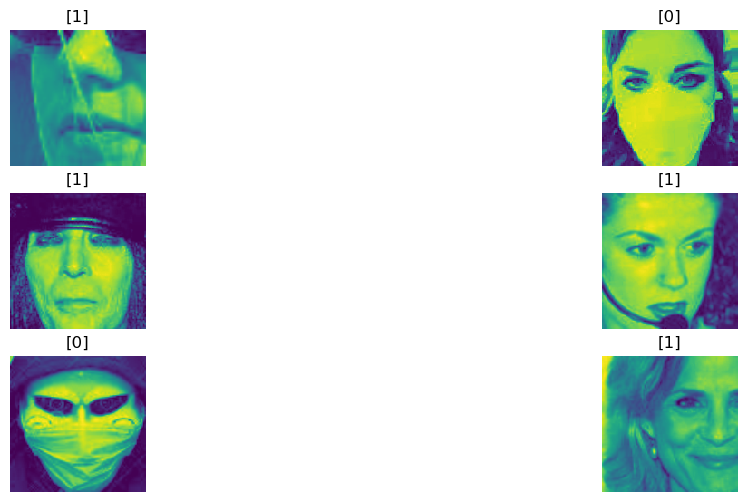

In [64]:
wrong_result = []
for i in range(0,len(y_val)):
    if prediction[i] != y_val[i]:
        wrong_result.append(i)
        
import random

samples = random.choices(population=wrong_result,k=6)
samples

plt.figure(figsize=(14,6))

for idx,n in enumerate(samples):
    plt.subplot(3,2,idx+1)
    plt.imshow(X_val[n].reshape(150,150),interpolation='nearest')
    plt.title(prediction[n])
    plt.axis('off')
